In [10]:
import numpy as np 
from sympy import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import binned_statistic, describe

import sys
sys.path.append('../../src/')
from aDNA_coal_sim import *
from plot_utils import *

%matplotlib inline

## Deriving the joint LD statistics

In [11]:
# Define variables in sympy... 
rho,t,eta,gamma = symbols('rho t \eta \gamma')

gamma = rho*(1  - exp(-t *(rho/2 + 1)))/(rho + 2)
eta = 2*(1  - exp(-t *(rho/2 + 1)))/(rho + 2)

eT_AT_B_200 = (rho**2 + 14*rho + 36)/(rho**2 + 13*rho + 18)
eT_AT_B_111 = (rho**2 + 13*rho + 24)/(rho**2 + 13*rho + 18)
eT_AT_B_022 = (rho**2 + 13*rho + 22)/(rho**2 + 13*rho + 18)

In [12]:
# Defining the staggered statistics (from the note)
e_TATB_200_anc = (1 - gamma)*eT_AT_B_200 + gamma*eT_AT_B_111
e_TATB_022_anc = (1 - eta).simplify() * eT_AT_B_022 + eta*eT_AT_B_111
e_TATB_111_mod_coupled = (1-gamma)*eT_AT_B_111 + gamma*eT_AT_B_022
e_TATB_111_mod_uncoupled = (1-eta)*eT_AT_B_111 + eta*eT_AT_B_200

# Simplifying the statistics
e_TATB_200_anc = e_TATB_200_anc.factor().simplify()
e_TATB_022_anc = e_TATB_022_anc.factor().simplify()
e_TATB_111_mod_coupled = e_TATB_111_mod_coupled.factor().simplify()
e_TATB_111_mod_uncoupled = e_TATB_111_mod_uncoupled.factor().simplify()


e_TATB_022_anc

(rho**3*exp(t*(rho + 2)/2) + 15*rho**2*exp(t*(rho + 2)/2) + 48*rho*exp(t*(rho + 2)/2) + 48*exp(t*(rho + 2)/2) - 4)*exp(-t*(rho + 2)/2)/((rho + 2)*(rho**2 + 13*rho + 18))

In [13]:
eD0DT_numerator = (e_TATB_200_anc - e_TATB_111_mod_coupled - e_TATB_111_mod_uncoupled + e_TATB_022_anc)

e_D0DT_numerator = eD0DT_numerator.factor().simplify()
e_D0DT_numerator

(rho + 10)*exp(-t*(rho + 2)/2)/(rho**2 + 13*rho + 18)

In [14]:
e_D0Dt_norm = e_D0DT_numerator / e_TATB_022_anc
e_D0Dt_norm # Note this does not actually go "negative"

(rho + 2)*(rho + 10)/(rho**3*exp(t*(rho + 2)/2) + 15*rho**2*exp(t*(rho + 2)/2) + 48*rho*exp(t*(rho + 2)/2) + 48*exp(t*(rho + 2)/2) - 4)

100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


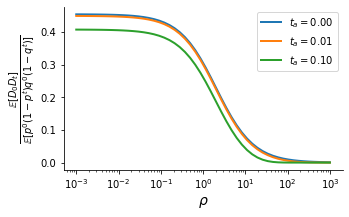

In [15]:
def eD0Dt_norm_eval(r,ta):
    """Function just to evaluate the expression..."""
    return(e_D0Dt_norm.evalf(subs={rho: r, t:ta}))

fig, ax = plt.subplots(1,1,figsize=(5,3))
rhos = np.logspace(-3, 3, 50)
tas = [0, 1e-2, 1e-1]
for ta in tqdm(tas):
    cur_d0dt_norm = np.array([eD0Dt_norm_eval(r,ta) for r in rhos])
    ax.plot(rhos, cur_d0dt_norm, lw=2, label=r'$t_a = %0.2f$' % ta)
    
ax.legend(fontsize=10)
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$', fontsize=14)
ax.set_ylabel(r'$\frac{\mathbb{E}[D_0D_t]}{\mathbb{E}[p^0(1-p^t)q^0(1 - q^t)]}$', fontsize=14)
debox(ax);
# plt.savefig('test.pdf', dpi=300, bbox_inches='tight')

## Plotting Simulation Results

In [16]:
tmpdir = '/scratch/midway2/abiddanda/aDNA_LD/ld_stats_raw/SerialConstant/'
file = tmpdir + 'jointLDstats_mod500_anc500_t100_l1_Ne10000_1_maf5_polytotal1.npz'
df = np.load(file)

In [19]:
rhos = df['rec_dist']*1e4*4
ed0dt = eD0Dt_norm = (df['Dmod']*df['Danc']) / (df['pAmod']*(1.-df['pAanc'])*df['pBmod']*(1. - df['pBanc']))
describe(rhos)

DescribeResult(nobs=490000, minmax=(0.0014195269, 398.7083), mean=199.60582, variance=13270.498, skewness=-0.002255635103210807, kurtosis=-1.2019194575665693)

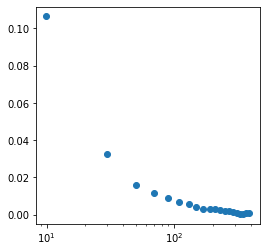

In [24]:
bin_means, bin_edges, binnumber = binned_statistic(rhos, ed0dt, np.nanmean, bins=20)

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.scatter(bin_edges[:-1] + (bin_edges[1:]- bin_edges[:-1])/2., bin_means)
ax.set_xscale('log')
ax.set_xlabel(r'$\hat{\rho}$', fontsize=14)
ax.set_ylabel(r'$\frac{\mathbb{E}[D_0D_t]}{\mathbb{E}[p^0(1-p^t)q^0(1 - q^t)]}$', fontsize=14)
debox(ax)